# Verkefni 1

Davíð Helgason  (dah38@hi.is)

Hieu

Hreiðar

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage # notum þetta fyrir myndir

import datetime # Notað til að mæla tímamismun.
import kmeans # Staðbundin skrá, fyrir k-means
import math # Stærðfræði
import glob # Notað til að finna skrár.

# Allt draslið er hér!
from prog import *

Hugtök
* centroid = þungamiðja, þyngdarpunktur, miðpunktur
* label = merki

Gögnin

## Fyrri hluti

Gögnin

In [2]:
albums = [load_image_as_arr(path) for path in glob.glob('albums/*.jpg')]

bundles_album = []
for i in range(len(albums)):
    bundles_album += [get_best_bundle(glob.glob('bundles/bundle-*.npy'), str(i), do_filter=True)]


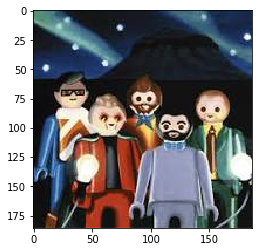

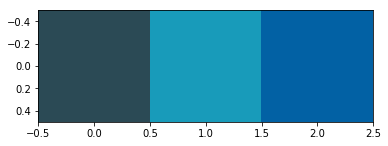

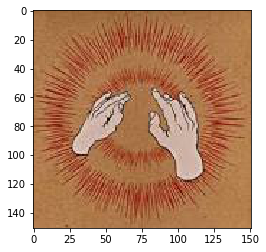

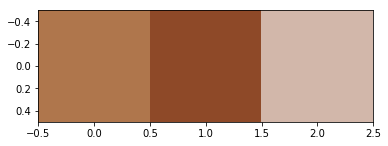

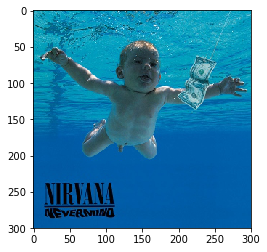

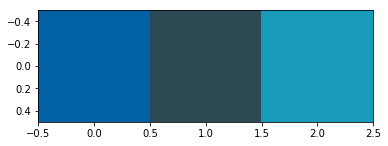

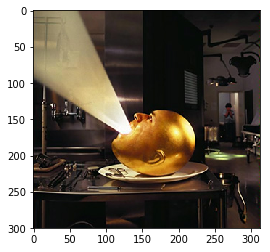

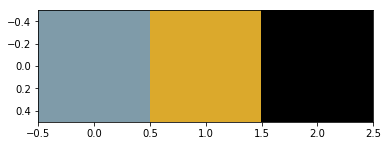

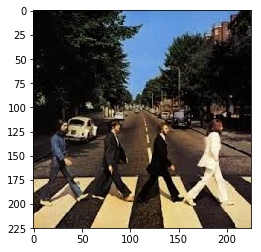

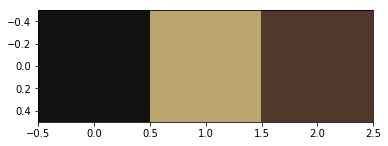

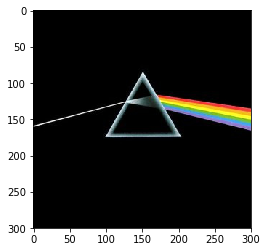

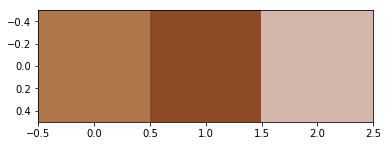

In [3]:
if True:
    for i, album in enumerate(albums):
        centroids = bundles_album[i]['centroids']
        display_arr(album)
        display_arr(np.array([centroids]))

## Seinni hluti

Verkferli

* (valfrjálst) skiptum inntakinu í 2 hluti, 90% til þjálfunar og 10% til að prófa
* Gera myndirnar (fylkið) tilbúnnar fyrir k-means
    * Fáum shape = (N, 28, 28) þar sem N er fjöldi mynda, viljum fá shape = (784, N)
    * Hver mynd verður að 784-vigri (28 x 28 = 784)
    * Notum:
        * reshape
        * transpose
        * etc..
* Þegar myndirnar eru orðnar tilbúnnar keyrum við k-means fyrir
    * k = 10, k = 20 og k = 30
* Fáum centroid fylki sem er shape (784, k)
* Breytum fulltrúunum (centroids) aftur í myndir, fáum k myndir, eina fyrir hvern fulltrúa.
* Þurfum að finna út hvaða merki (e. labels) hver þungamiðjupunktur (e. centroid) er fulltrúi fyrir.
    * Skoða hvaða myndir tilheyra þyrpingunni.
    * Mæla fjarlægðir milli hvers vigurs og þungamiðjupunkts og þannig gefa því merki samkvæmt því.
* Nota fulltrúanna til að greina myndirnar í test menginu og mæla villu í prósentum.
* Randome-a röðun á myndum?

In [4]:
A_images = np.load("mnist/A_images.npy")
A_labels = np.load("mnist/A_labels.npy")

B_images = np.load("mnist/B_images.npy")
B_labels = np.load("mnist/B_labels.npy")

In [5]:
bundle10 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "10", do_filter=True)
bundle20 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "20", do_filter=True)
bundle30 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "30", do_filter=True)


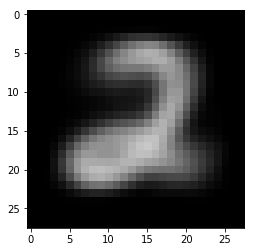

Centroid 1 / 10 is
   2  with a prob. of 91 %
   3  with a prob. of 3 %
   6  with a prob. of 1 %



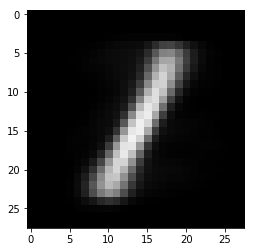

Centroid 2 / 10 is
   1  with a prob. of 77 %
   2  with a prob. of 7 %
   7  with a prob. of 5 %



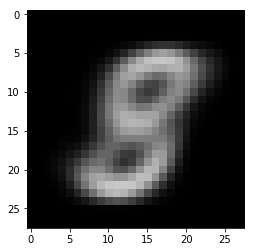

Centroid 3 / 10 is
   8  with a prob. of 43 %
   5  with a prob. of 22 %
   3  with a prob. of 21 %



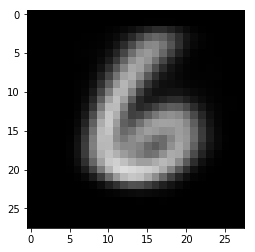

Centroid 4 / 10 is
   6  with a prob. of 85 %
   0  with a prob. of 4 %
   2  with a prob. of 2 %



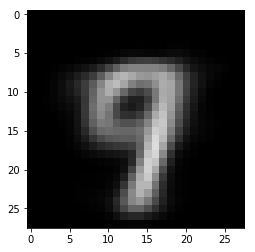

Centroid 5 / 10 is
   7  with a prob. of 36 %
   9  with a prob. of 32 %
   4  with a prob. of 21 %



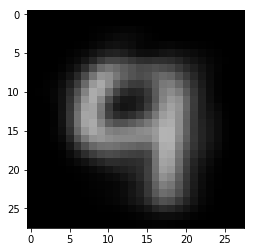

Centroid 6 / 10 is
   4  with a prob. of 40 %
   9  with a prob. of 25 %
   7  with a prob. of 11 %



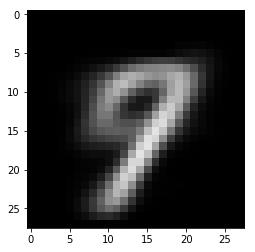

Centroid 7 / 10 is
   7  with a prob. of 41 %
   9  with a prob. of 27 %
   4  with a prob. of 24 %



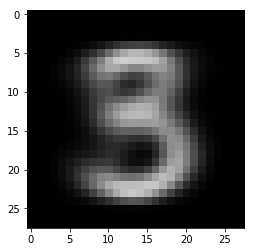

Centroid 8 / 10 is
   3  with a prob. of 51 %
   5  with a prob. of 19 %
   8  with a prob. of 17 %



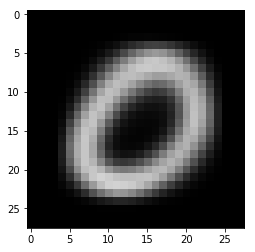

Centroid 9 / 10 is
   0  with a prob. of 94 %
   6  with a prob. of 1 %
   5  with a prob. of 1 %



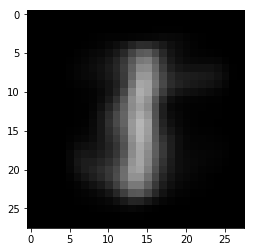

Centroid 10 / 10 is
   1  with a prob. of 41 %
   5  with a prob. of 17 %
   2  with a prob. of 9 %

--- --- --- ---


In [6]:
if True:
    test_bundle(bundle10, A_images, A_labels)

In [7]:
if False:
    test_bundle(bundle20, A_images, A_labels)

In [8]:
if False:
    test_bundle(bundle30, A_images, A_labels)

In [9]:
# Plot number of iterations and total loss (error) at each point
#plt.plot(range(0, len(losses)), losses)


In [10]:
#test(bundles[0], the_images, the_labels)

In [11]:
#test(the_images, the_labels, 20)

In [12]:
#test(the_images, the_labels, 30)

In [13]:
bundle_1_paths = glob.glob('_ignore/bundle-*.npy')
print(bundle_1_paths)

[]


In [14]:
# stat[centroid][top_result][digit, ratio]
def label_suggestions(images, image_labels, centroids, labels, losses):
    stat = []
    for _ in centroids:
        sub = []
        for i in range(len(centroids)):
            sub += [[i, 0]]
        stat += [sub]
    
    for i, label in enumerate(labels):
        value = int(image_labels[i])
        stat[label][value][1] += 1
        #print(label, value)
        
    for i, it in enumerate(stat):
        n = sum([x[1] for x in it])
        stat[i] = sorted(it, key=lambda x: -x[1])
        for j in range(len(stat[i])):
            stat[i][j][1] /= n
            
    return stat



# x and y are vectors
def get_distance(x, y):
    u = x - y
    return np.dot(u,u)


def classifier_factory(images, image_labels, centroids, labels, losses):
    suggestions = label_suggestions(images, image_labels, centroids, labels, losses)
    #print(suggestions)
    def classifier(image, display_best=False, metric=get_distance):
        
        #print(image.shape)
        # Convert to 784 vector
        vimage = image.reshape(-1)
        #print(vimage.shape)
        
        distances = []
        # Measure distances between input image and centroids
        
        least_index = None
        least_distance = None
        uninitialized = True
        
        for i, centroid in enumerate(centroids):
            vcentroid = centroid.reshape(-1)
            distance = metric(vimage, vcentroid)
            distances += [[i, distance]]
            
        
        #print("Least distance:", least_distance)
        #print("Least index:", least_index)
        
        distances = sorted(distances, key=lambda x: x[1])
        print(distances)
        
        
        least_index = distances[0][0]
        
        maxed_digit = suggestions[least_index][0][0]
        
        if display_best:
            display_arr(centroids[least_index])
        
        #print(maxed_digit)
                
                
        digit = maxed_digit
        
        return digit
    return classifier


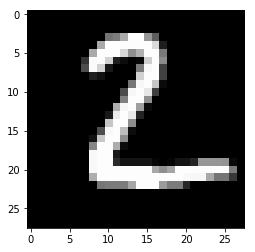

Actual: 2
[[7, 4296515.3109185016], [9, 4349818.0003956668], [3, 4662083.1351391645], [0, 4943188.7060480854], [2, 5074911.8278125897], [1, 5631444.2444009185], [5, 6179590.7930717636], [8, 6269891.179132415], [4, 6426733.7396105863], [6, 6712498.1263496112]]


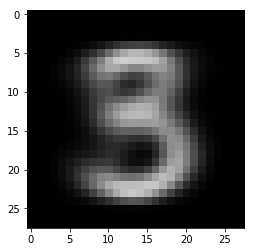

Got: 3


In [15]:
def testzzz(idx, bundle, images, labels):
    classifier = classifier_factory(A_images, A_labels, bundle['centroids'], bundle['labels'], bundle['losses'])
    label = int(labels[idx][0])
    display_arr(images[idx])
    print("Actual:", label)
    digit = classifier(images[idx], display_best=True)
    print("Got:", digit)

testzzz(1, bundle10, B_images, B_labels)

In [16]:


def testzq(bundle, images, labels):
    classifier = classifier_factory(A_images, A_labels, bundle['centroids'], bundle['labels'], bundle['losses'])
    N = len(images)
    N_correct = 0
    N_incorrect = 0
    
    for i in range(N):
        label = int(labels[i][0])
        digit = classifier(images[i])
        if digit == label:
            N_correct += 1
        else:
            N_incorrect += 1
        #print("Classified digit:", digit)
        #print("Actual digit:", b_label)
    print("Nr. of corrects:", N_correct)
    print("Nr. of incorrects:", N_incorrect)
    print("% correct:", int(100 * (N_correct / N)), "%")

In [17]:
print("k = 10")
testzq(bundle10, B_images, B_labels)
print()
print("k = 20")
testzq(bundle20, B_images, B_labels)
print()
print("k = 30")
testzq(bundle30, B_images, B_labels)


k = 10
[[6, 2251527.404758702], [4, 2266020.5440136339], [9, 3259418.4568521227], [5, 3514527.1370888576], [2, 3817752.8863278734], [7, 4354296.2067694757], [0, 4366835.7032932639], [3, 4746277.5773160364], [1, 4839101.6112487437], [8, 5465260.548829386]]
[[7, 4296515.3109185016], [9, 4349818.0003956668], [3, 4662083.1351391645], [0, 4943188.7060480854], [2, 5074911.8278125897], [1, 5631444.2444009185], [5, 6179590.7930717636], [8, 6269891.179132415], [4, 6426733.7396105863], [6, 6712498.1263496112]]
[[1, 1188696.7090748316], [9, 1258875.8922875579], [6, 2824936.9634708231], [2, 3264311.6679872619], [7, 3334541.9078702377], [4, 3387815.2916850983], [0, 3574450.7831830704], [5, 3575504.8336700541], [3, 3665653.4707400724], [8, 5561532.8409505971]]
[[8, 2574721.676102112], [3, 3647534.0444362173], [2, 4535734.7658038558], [7, 4841461.9578278996], [0, 4899629.5435136501], [4, 4979924.0291956831], [5, 5030554.7823880035], [6, 5256851.6680162773], [9, 5931448.9703656361], [1, 7637533.070487

## Búa til gögn

Skoða skránna `generate_data.ipynb`.